In [27]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
from scipy.ndimage import gaussian_filter
from PIL import Image

%matplotlib inline

random = np.random.default_rng()
np.set_printoptions(precision=2)

# Using the dataset in a simple autoencoder

In [28]:
class NumpyArrayDataset(Dataset):
    def __init__(self, path):
        self.npzfile = np.load(path)
        self.img_shape = self.npzfile[self.npzfile.files[0]][0].shape
    
    def __getitem__(self, idx):
        img = self.npzfile[self.npzfile.files[idx]].astype(np.single)
    
        entry = self.npzfile[self.npzfile.files[idx]]
    
        # For compatibility with the convolutional layers in the
        # network, we need to reshape the image to make it explicit 
        # that the image consists of one layer. 
        noisy_image = 100 * np.reshape(entry[0], (1, *self.img_shape))
        true_image  = 100 * np.reshape(entry[1], (1, *self.img_shape))
    
        # entry[0] is the noisy image, entry[1] is the true image. The
        # goal will be for the network to learn the mapping
        # noisy --> true.
        return (noisy_image.astype(np.single), true_image.astype(np.single), idx)
    
    def __len__(self):
        return len(self.npzfile)

In [29]:
path = "shapes-dataset-new.npz"

# Load the shapes dataset as a PyTorch Dataset
shapes_dataset = NumpyArrayDataset(path)

# Split into test and training set
n = len(shapes_dataset)
train_size = 4 * n // 5
test_size = n - train_size

train_data, test_data = random_split(shapes_dataset, 
                                     [train_size, test_size])

# Construct the DataLoaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=8)
test_loader  = DataLoader(test_data,  batch_size=8)

In [30]:
len(train_data), len(test_data)

(819, 205)

## Verifying all the dimensions

In [31]:
# The dimensions of an element of the train loader are:
# (batch size, channels, image width, image height)
thing = next(iter(train_loader))
print(type(thing))
print(len(thing))
print(type(thing[0]))
print(type(thing[1]))
print(thing[0].shape)
print(thing[1].shape)

<class 'list'>
3
<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([8, 1, 128, 128])
torch.Size([8, 1, 128, 128])


## Training definitions

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, 
                 stride=1, padding=1, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                              stride, padding)
        self.relu = nn.LeakyReLU(0.2)
        self.max_pool = nn.MaxPool2d(2)
        
    def forward(self, x):
        return self.max_pool(self.relu(self.conv(x)))        

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels,
                                         kernel_size, stride, padding,
                                         bias=False)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.relu(
#                          self.batch_norm(
                                         self.deconv(x)
#                          )
               )

class DiscriminatorBlock(nn.Module):
    pass

class Reshaper(nn.Module):
    def __init__(self, *shape):
        self.shape = shape
        super(Reshaper, self).__init__()
    def forward(self, x):
        return x.view(self.shape)

In [33]:
def update_discriminator(batch_true, batch_noisy, generator, 
                         discriminator, bce_loss, optimizer_D,
                         should_print=False):    
    optimizer_D.zero_grad()
    
    reconstructions = generator(batch_noisy)
    
    # For both original data and reconstructions, the probability that
    # the data is original according to the discriminator.
    probs_orig = discriminator(batch_true)
    probs_rec  = discriminator(reconstructions.detach())
        
    batch_size = probs_orig.shape[0]
    
    loss1 = bce_loss(probs_orig, 
                     torch.ones((batch_size, 1), 
                                device=batch_true.device))
    
    loss2 = bce_loss(probs_rec, 
                     torch.zeros((batch_size, 1),
                                 device=batch_true.device))
    
    loss = (loss1 + loss2) / 2
    
    if should_print:
        print(probs_orig.cpu().detach().numpy()[:, 0], probs_rec.cpu().detach().numpy()[:, 0], end=" ")
        print(f"{loss1.item():.2f}, {loss2.item():.2f}")
    
#     print(f"Probs orig: {probs_orig.detach().cpu().numpy().flatten()} \
#             probs rec: {probs_rec.detach().cpu().numpy().flatten()} \
#             loss1: {loss1.item():.2f}, loss2: {loss2.item():.2f}")
    
    loss.backward()
    optimizer_D.step()
    
    return loss

def update_generator(batch_true, batch_noisy, generator, discriminator, 
                     mse_loss, bce_loss, optimizer_G, alpha):
    """alpha determines the balance between mse loss and bce loss."""
    batch_size = batch_true.shape[0]
    
    ones = torch.ones((batch_size, 1), device=batch_true.device)
    
    # I'm not sure about this one
    optimizer_D.zero_grad()
    
    optimizer_G.zero_grad()
    
    reconstructions = generator(batch_noisy)
    # This needs to be recomputed, because the parameters for the
    # discriminator were updated just now.
    probs_rec = discriminator(reconstructions)
    
    loss = alpha * bce_loss(probs_rec, ones.reshape(probs_rec.shape)) + \
           (1 - alpha) * mse_loss(reconstructions, batch_true)
    
    loss.backward()
    optimizer_G.step()
    
    return loss

# Training initialization

In [35]:
generator = nn.Sequential(
    EncoderBlock(1, 8, 3, padding=1),
    EncoderBlock(8, 8, 3, padding=1),
    DecoderBlock(8, 8, 2, stride=2),
    DecoderBlock(8, 8, 2, stride=2),
    nn.Conv2d(8, 1, 3, padding=1),
).to(device)

discriminator = nn.Sequential(
    EncoderBlock(1, 8, 3, stride=2, padding=1),
    EncoderBlock(8, 8, 3, stride=2, padding=1),
    nn.Flatten(),
    nn.Linear(8 * 8 * 8, 1),
    nn.Sigmoid()
    # We could also use BCEWithLogitsLoss, and then we would not 
    # need the sigmoid.
).to(device)

# discriminator = nn.Sequential(
#     nn.Conv2d(1, 6, kernel_size=3, padding=1), nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2, stride=2),
#     nn.Conv2d(6, 16, kernel_size=3, padding=1), nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2, stride=2),
#     nn.Conv2d(16, 16, kernel_size=3, padding=1), nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2, stride=2),
#     nn.Conv2d(16, 16, kernel_size=3, padding=1), nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2, stride=2),
#     nn.Flatten(),
#     nn.Linear(1024, 120), nn.ReLU(),
#     nn.Linear(120, 84), nn.ReLU(),
#     nn.Linear(84, 1), nn.Sigmoid()
# ).to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.005, 
                         betas=[0.5, 0.999])
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.005, 
                         betas=[0.5, 0.999])
# optimizer_G = optim.SGD(generator.parameters(), lr=0.001)
# optimizer_D = optim.SGD(discriminator.parameters(), lr=0.001)

mse_loss = nn.MSELoss(reduction='sum')
bce_loss = nn.BCELoss(reduction='sum')

for weights in generator.parameters():
    nn.init.normal_(weights, 0, 0.02)
    
# for weights in discriminator.parameters():
#     nn.init.normal_(weights, 0, 0.02)
    
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)

discriminator.apply(init_weights);

# Training

In [36]:
num_epochs = 60
# k = 1
alpha = 0.005

for epoch in range(num_epochs):
    # Tell Torch that we are in training.
    generator.train()
    discriminator.train()
    
    train_loss_d = 0
    train_loss_g = 0
    test_loss = 0
    # Loop through the dataset
    for batch_true, batch_noisy, idxs in train_loader:
        # Move the data to the GPU
        batch_noisy = batch_noisy.to(device)
        batch_true = batch_true.to(device)
    
#         for i in range(k):
        if alpha != 0:
            loss_d = \
                update_discriminator(batch_true, batch_noisy, generator, 
                                     discriminator, bce_loss, optimizer_D)
        
        loss_g = \
            update_generator(batch_true, batch_noisy, generator, 
                             discriminator, mse_loss, bce_loss, 
                             optimizer_G, alpha)        
        
        if alpha != 0: train_loss_d += loss_d.item()
        train_loss_g += loss_g.item()
        
    # Calculate the average train loss this epoch
    if alpha != 0: train_loss_d /= len(train_loader)
    train_loss_g /= len(train_loader)
    
    if alpha == 0: print(f"Epoch {epoch}, loss: G {train_loss_g:0.6f}", end="")
    if alpha != 0: 
        print(f"Epoch {epoch}, loss: G {train_loss_g:0.6f}, D {train_loss_d:0.6f}", 
          end="")
    
    # Calculate the average test loss this epoch
    generator.eval()
    
    with torch.no_grad():
        for batch_true, batch_noisy, idx in test_loader:
            batch_true = batch_true.to(device)
            batch_noisy = batch_noisy.to(device)
            
            out = generator(batch_noisy)
            test_loss += mse_loss(out, batch_true)
            
    test_loss /= len(test_loader)
    print(f", test loss {test_loss:0.6f}")

Epoch 0, loss: G 430.550218, D 4.673518, test loss 162.126541
Epoch 1, loss: G 161.394587, D 1.500150, test loss 143.094467
Epoch 2, loss: G 139.308674, D 0.671708, test loss 117.279282
Epoch 3, loss: G 121.008388, D 0.616859, test loss 99.075752
Epoch 4, loss: G 107.178704, D 0.636869, test loss 92.276222
Epoch 5, loss: G 101.241586, D 0.363373, test loss 88.459534
Epoch 6, loss: G 97.503301, D 0.341882, test loss 85.675240
Epoch 7, loss: G 94.854811, D 0.278330, test loss 83.395630
Epoch 8, loss: G 92.215673, D 0.164643, test loss 81.246696
Epoch 9, loss: G 91.052654, D 0.120674, test loss 79.342278
Epoch 10, loss: G 87.762630, D 0.111084, test loss 77.406883
Epoch 11, loss: G 85.864715, D 0.100724, test loss 75.699966
Epoch 12, loss: G 83.955727, D 0.079988, test loss 74.206413
Epoch 13, loss: G 82.170407, D 0.065068, test loss 72.867744
Epoch 14, loss: G 80.596971, D 0.067010, test loss 71.744278
Epoch 15, loss: G 79.161218, D 2.288510, test loss 70.816391
Epoch 16, loss: G 78.1613

In [ ]:
num_epochs = 40

for epoch in range(num_epochs):
    # Tell Torch that we are in training.
    discriminator.train()
    
    train_loss_d = 0
    # Loop through the dataset
    for batch_num, (batch_true, batch_noisy, idxs) in enumerate(train_loader):
        # Move the data to the GPU
        batch_noisy = batch_noisy.to(device)
        batch_true = batch_true.to(device)
    
        loss_d = \
            update_discriminator(batch_true, batch_noisy, generator, 
                                 discriminator, bce_loss, optimizer_D,
                                 should_print=False)     
        
        train_loss_d += loss_d.item()
        
    # Calculate the average train loss this epoch
    train_loss_d /= len(train_loader)
    print(f"Epoch {epoch}, loss: D {train_loss_d:0.6f}")

In [37]:
with torch.no_grad():
    for batch_true, batch_noisy, idxs in train_loader:
        batch_true = batch_true.to(device)
        batch_noisy = batch_noisy.to(device)
        
        batch_size = batch_true.shape[0]
        
        ones  = torch.ones((batch_size,), device=batch_true.device)
        zeros = torch.zeros((batch_size,), device=batch_true.device)
        
        probs_rec = discriminator(generator(batch_noisy))
#         print(bce_loss(probs_rec, zeros.reshape(probs_rec.shape)))
               
        probs_orig = discriminator(batch_true)        
#         print(bce_loss(probs_orig, ones.reshape(probs_orig.shape)))
#         print(bce_loss(probs_rec, ones.reshape(probs_orig.shape)))
        
        
        print(probs_rec)
        print(probs_orig)
        
#         print(probs_rec, zeros, ones)

tensor([[2.6543e-03],
        [7.9045e-04],
        [2.8140e-03],
        [3.9681e-03],
        [4.3054e-05],
        [7.5689e-03],
        [2.5369e-02],
        [6.2921e-04]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.9999]], device='cuda:0')
tensor([[0.0004],
        [0.0015],
        [0.0029],
        [0.0003],
        [0.0037],
        [0.0001],
        [0.0025],
        [0.0010]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[2.9964e-02],
        [1.6064e-02],
        [3.0411e-05],
        [3.8578e-02],
        [5.9735e-05],
        [9.8031e-04],
        [1.2845e-01],
        [1.6528e-04]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.9756],
        [1.0000],


tensor([[0.9998],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.9997],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[7.6655e-02],
        [3.7987e-01],
        [3.7879e-06],
        [6.7932e-05],
        [4.8735e-05],
        [1.0945e-02],
        [2.4785e-04],
        [5.8390e-06]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.9999],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[1.6939e-04],
        [1.1827e-05],
        [1.8710e-04],
        [1.1978e-03],
        [4.9987e-04],
        [7.5438e-04],
        [8.3785e-05],
        [1.0586e-03]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[0.0014],
        [0.0003],
        [0.0005],
        [0.0025],
        [0.0006],
        [0.0065],
        [0.0030],


tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[9.2342e-03],
        [2.9844e-03],
        [3.7317e-04],
        [1.3672e-03],
        [9.5605e-05],
        [3.4181e-05],
        [2.5571e-03],
        [6.9563e-03]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.9962],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[1.4903e-02],
        [1.0217e-04],
        [1.4412e-02],
        [8.0203e-02],
        [5.4996e-02],
        [3.9215e-04],
        [5.8708e-04],
        [2.2360e-05]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[3.8667e-01],
        [3.2719e-04],
        [2.5157e-02],
        [3.6904e-06],
        [3.0263e-03],
        [1.6406e

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[1.5892e-01],
        [1.1163e-02],
        [2.2517e-02],
        [6.3994e-05],
        [5.4448e-04],
        [6.4707e-03],
        [3.4355e-01],
        [1.2161e-01]], device='cuda:0')
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
tensor([[2.0376e-03],
        [2.1524e-04],
        [1.6551e-04],
        [3.8731e-05],
        [2.1575e-03],
        [8.0094e-03],
        [5.1753e-05],
        [1.0869e-04]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [0.9989],
        [1.0000],
        [1.0000],
        [0.9968],
        [1.0000]], device='cuda:0')
tensor([[9.2555e-03],
        [7.2079e-04],
        [1.0861e-01],
        [1.4680e-02],
        [3.8059e-04],
        [1.2835e-03],
        [4.7637e-07],
    

## Visualise the results of the network

In [38]:
def show_batches(*args):
    """It is assumed that all tensors contain an equal number of
    images."""
    batch_tensors = args
    
    # Assert that we are working with a grayscale iamge
    assert all(tensor.shape[1] == 1 for tensor in batch_tensors)
    
    num_batches = len(batch_tensors)
    num_images = batch_tensors[0].shape[0]
    
    fig, axs = plt.subplots(num_images, num_batches, 
                            figsize=(5 * num_batches, 5 * num_images))
    
    for i in range(num_images):
        for j in range(num_batches):
            pic = axs[i, j].imshow(batch_tensors[j][i, 0], 
#                                    vmin=-0.5, vmax=1, 
                                   cmap=plt.cm.Greys_r)
            
            plt.colorbar(pic, ax=axs[i,j])

0.022833887
0.024777783
0.02762067
0.025702082
0.018642647
0.02325395
0.025712734
0.021241385


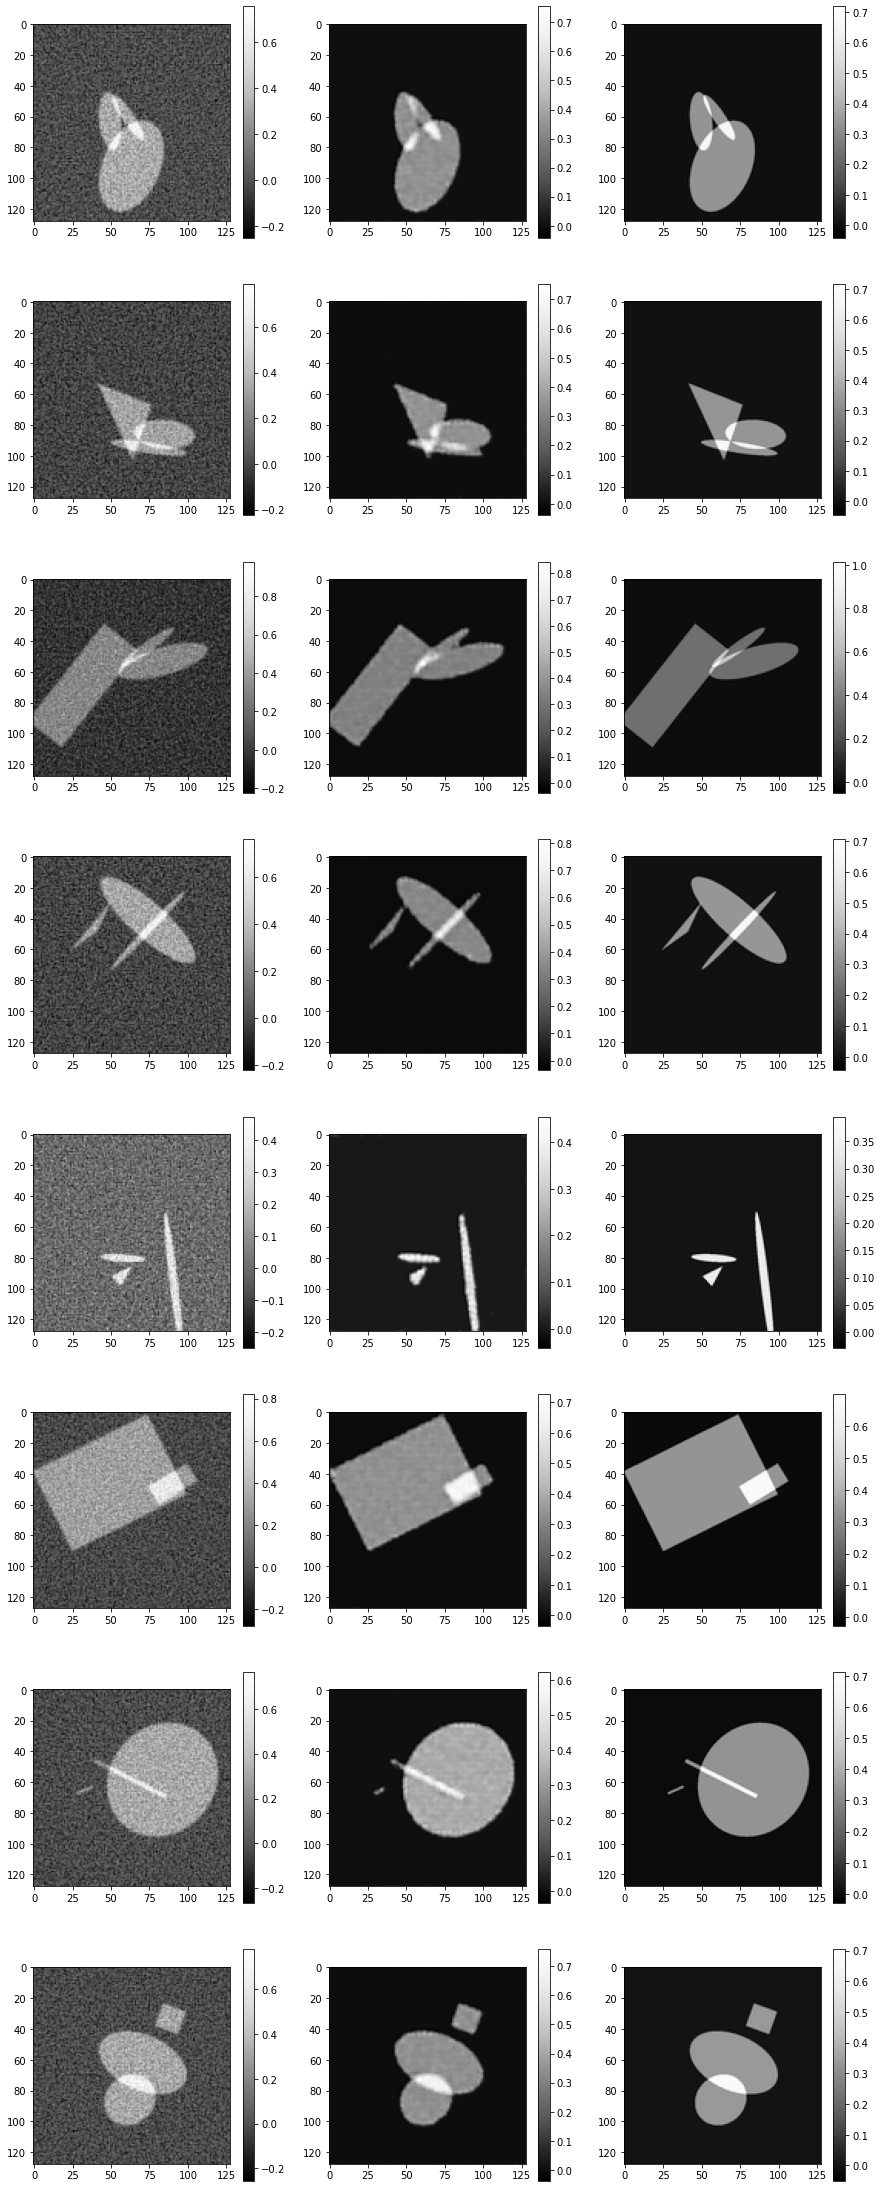

In [39]:
with torch.no_grad():
    for batch_true, batch_noisy, idxs in test_loader:
        model_output = generator(batch_noisy.to(device))
        
        for i in range(batch_true.shape[0]):
            img_orig = batch_true[i, 0] / 100
            img_rec = model_output[i, 0] / 100
            
            print(np.linalg.norm(img_orig - img_rec.cpu()))
        
        show_batches(batch_noisy, model_output.cpu(), batch_true)
        break

## Save the trained model to a file

In [40]:
torch.save(generator.state_dict(), 'trained-model-working-version.pth')

In [42]:
other_model = nn.Sequential(
    EncoderBlock(1, 8, 3, padding=1),
    EncoderBlock(8, 8, 3, padding=1),
    DecoderBlock(8, 8, 2, stride=2),
    DecoderBlock(8, 8, 2, stride=2),
    nn.Conv2d(8, 1, 3, padding=1),
).to(device)
other_model.load_state_dict(torch.load('trained-model-working-version.pth'))

<All keys matched successfully>

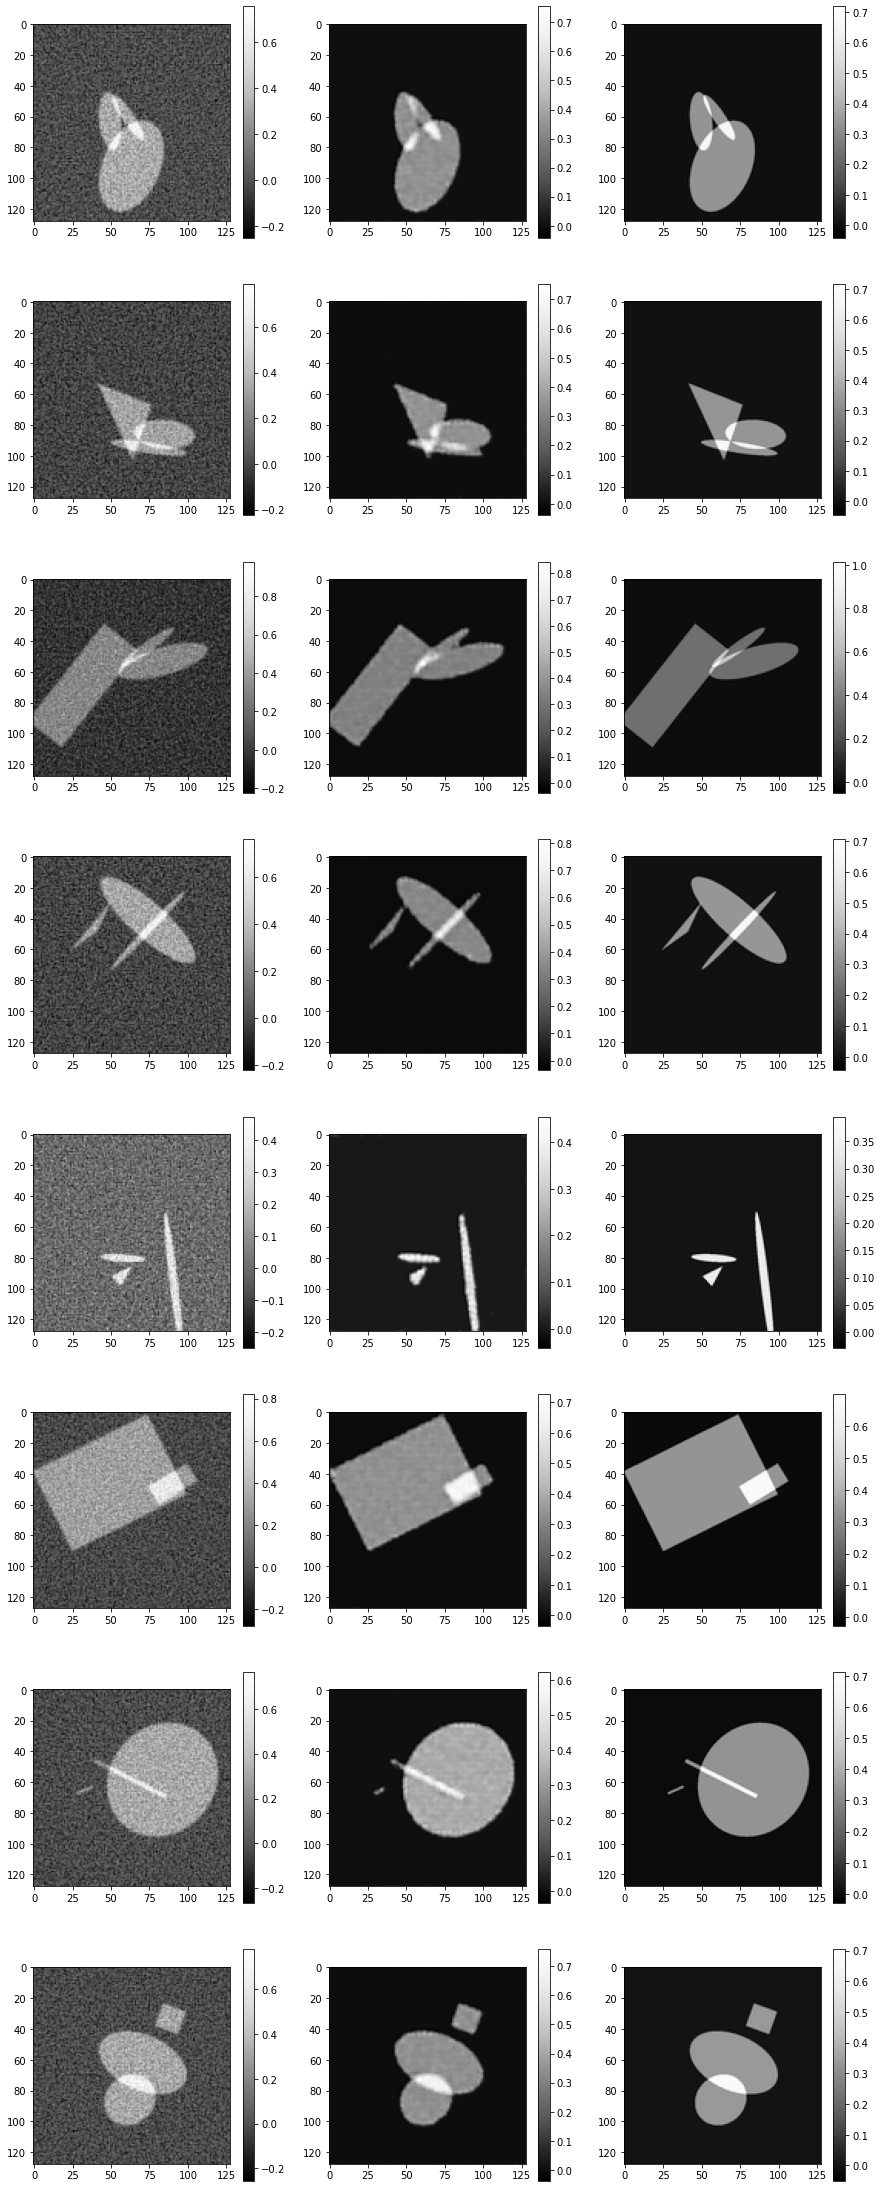

In [44]:
other_model.to(device)

with torch.no_grad():
    for batch_true, batch_noisy, idxs in test_loader:
        model_output = other_model(batch_noisy.to(device))
        show_batches(batch_noisy, model_output.cpu(), batch_true)
        break

# The big library of old code
## Dimension checking code

In [26]:
X = torch.rand(size=(1, 1, 128, 128), dtype=torch.float32).to(device)

for layer in generator:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)
    
X = torch.rand(size=(1, 1, 128, 128), dtype=torch.float32).to(device)

for layer in discriminator:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

EncoderBlock output shape: 	 torch.Size([1, 8, 32, 32])
EncoderBlock output shape: 	 torch.Size([1, 16, 8, 8])
EncoderBlock output shape: 	 torch.Size([1, 32, 2, 2])
EncoderBlock output shape: 	 torch.Size([1, 64, 1, 1])
DecoderBlock output shape: 	 torch.Size([1, 32, 2, 2])
DecoderBlock output shape: 	 torch.Size([1, 16, 3, 3])


RuntimeError: Given transposed=1, weight of size [64, 8, 2, 2], expected input[1, 16, 3, 3] to have 64 channels, but got 16 channels instead

## Old generator code

In [ ]:
# NOTE: this is a toy model taken from the internet to test the combination
# of the shape dataset + autoencoder + lisa. The final model will have many
# architectural changes, we still need to implement GAN loss for instance,
# and flatten the data in the middle as is usual in convolutional
# autoencoders.
# Source: https://analyticsindiamag.com/how-to-implement-convolutional-autoencoder-in-pytorch-with-cuda/

# class ConvAutoencoder(nn.Module):
#     def __init__(self):
#         super(ConvAutoencoder, self).__init__()
       
#         self.relu = nn.ReLU()
#         self.max_pool = nn.MaxPool2d(2)
#         self.linear = nn.Linear(128 * 128, 128 * 128)
        
#         #Encoder
#         self.conv1 = nn.Conv2d(1,  8,  3, padding=1)  
#         self.conv2 = nn.Conv2d(8,  16, 3, padding=1)
#         self.conv3 = nn.Conv2d(16, 16, 3, padding=1)
        
       
#         #Decoder
#         self.deconv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
#         self.deconv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)


#     def forward(self, x):
#         x = self.relu(self.conv1(x))
#         x = self.pool(x)
#         x = self.relu(self.conv2(x))
#         x = self.pool(x)
#         x = self.relu(self.conv3(x))
#         x = x.view((-1, 4096, 4096))
#         x = self.linear(4096, 4096),
#         x = x.view((-1, 16, 16, 16))
#         x = self.deconv1(x)
#         x = self.deconv2(x)
              
#         return x
# generator = nn.Sequential(    
#     nn.Conv2d(1,  16,  3, padding=1), nn.ReLU(),
#     nn.MaxPool2d(2),
#     nn.Conv2d(16,  4, 3, padding=1), nn.ReLU(),
#     nn.MaxPool2d(2),
# #     nn.Conv2d(8, 8, 3, padding=1), nn.ReLU(),
# #     nn.MaxPool2d(2),
# #     nn.Flatten(),
# #     nn.Linear(2048, 2048),
# #     Reshaper(-1, 8, 16, 16),
#     nn.ConvTranspose2d(4, 16, 2, stride=2), nn.ReLU(),
#     nn.ConvTranspose2d(16, 1, 2, stride=2), nn.Sigmoid()
# #     nn.ConvTranspose2d(8, 1, 2, stride=2)
# ).to(device)

# generator = nn.Sequential(
#     nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2),
#     nn.Conv2d(in_channels=8, 16, 3, padding=1),
#     nn.ReLU(),
#     nn.MaxPool2d(2),
#     nn.Conv2d(16, 16, 3, padding=1),
#     nn.MaxPool2d(2),
#     nn.Flatten(),
#     nn.Linear(4096, 4096),
    
    
# )
    
# model = nn.Sequential(
#     nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
#     nn.AvgPool2d(kernel_size=2, stride=2),
#     nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
#     nn.AvgPool2d(kernel_size=2, stride=2),
#     nn.Flatten(),
# #     nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
# #     nn.Linear(120, 84), nn.Sigmoid(),
# #     nn.Linear(84, 10)
# ).to(device)

## Old training code

In [ ]:
# epochs = 100

# for epoch in range(epochs):
#     loss = 0
#     for batch_true, batch_noisy in train_loader:
#         # reshape mini-batch data to [N, 784] matrix
#         # load it to the active device
#         batch_noisy = batch_noisy.to(device)
#         batch_true = batch_true.to(device)
        
#         # reset the gradients back to zero
#         # PyTorch accumulates gradients on subsequent backward passes
#         optimizer.zero_grad()
        
#         # compute reconstructions
#         outputs = model(batch_noisy.float())
        
#         # compute training reconstruction loss
#         train_loss = criterion(outputs, batch_true)
        
#         # compute accumulated gradients
#         train_loss.backward()
        
#         # perform parameter update based on current gradients
#         optimizer.step()
        
#         # add the mini-batch training loss to epoch loss
#         loss += train_loss.item()
    
#     # compute the epoch training loss
#     loss = loss / len(train_loader)
    
#     # display the epoch training loss
#     if epoch % 5 == 0:
#         print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))